In [10]:
import keras
import matplotlib.pyplot as plt
import numpy as np

In [11]:
dataset = keras.datasets.mnist.load_data()

In [12]:
(x_train, y_train), (x_test, y_test) = dataset

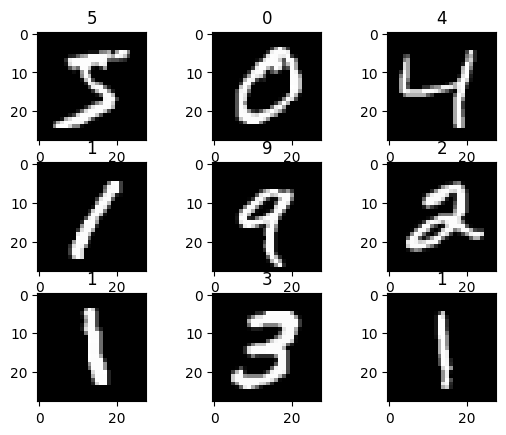

In [13]:

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
    plt.title(y_train[i])
    


In [14]:
rows, cols,channels = 28, 28, 1
img_shape = (rows, cols, channels)
noise_shape = (128,)

In [15]:
def build_generator():
    return keras.Sequential(
        [
            keras.layers.InputLayer(shape=noise_shape),
            keras.layers.Dense(256),
            keras.layers.LeakyReLU(negative_slope=0.2),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(512),
            keras.layers.LeakyReLU(negative_slope=0.2),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(1024),
            keras.layers.LeakyReLU(negative_slope=0.2),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(np.prod(img_shape), activation="tanh"),
            keras.layers.Reshape(img_shape),
        ]
        ,name="generator"
    )

def build_discriminator():
    return keras.Sequential(
        [
            keras.layers.InputLayer(shape=img_shape),
            keras.layers.Flatten(),
            keras.layers.Dense(512),
            keras.layers.LeakyReLU(negative_slope=0.2),
            keras.layers.Dense(256),
            keras.layers.LeakyReLU(negative_slope=0.2),
            keras.layers.Dense(1, activation="sigmoid"),
        ],
        name="discriminator",
    )


In [16]:
epochs = 100
batch_size = 32
save_interval = 10
half_batch = batch_size // 2
optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
generator = build_generator()
discriminator = build_discriminator()
generator.compile(optimizer=optimizer, loss="binary_crossentropy")
discriminator.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

z = keras.Input(shape=noise_shape)
img = generator(z)
discriminator.trainable = False
valid = discriminator(img)

combined = keras.Model(z, valid)
combined.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 128))
    gen_imgs = generator.predict(noise, verbose=0)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig(f"images/mnist_{epoch}.png" )
    plt.close()

In [17]:
# scale the images so [0,255] -> [-1, 1]
x_train = x_train.astype("float32") / (255/2) - 1
x_test = x_test.astype("float32") / (255/2) - 1
# expand the channel dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

for epoch in range(epochs):
    # ---------------------
    #  Train Discriminator
    # ---------------------

    # Select a random half batch of images
    idx = np.random.randint(0, x_train.shape[0], half_batch)
    imgs = x_train[idx]

    # Sample noise and generate a batch of new images
    noise = np.random.normal(0, 1, (half_batch, 128))
    gen_imgs = generator.predict(noise, verbose=0)

    # Train the discriminator
    d_loss_real =  discriminator.train_on_batch(imgs,np.ones((half_batch,1)))
    d_loss_fake = discriminator.train_on_batch(gen_imgs,np.zeros((half_batch,1)))
    
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    # ---------------------
    #  Train Generator
    # ---------------------
    noise = np.random.normal(0, 1, (batch_size, 128))

    # Train the generator
    g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))
    

    print(f"{epoch} [D loss: {d_loss[0]:.4f}, acc.: {100*d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")
    
    if epoch % save_interval == 0:
        # save the _images 
        save_imgs(epoch)

c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:71: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


epoch: 0 d_loss: [0.73681164 0.375     ] g_loss: [array(0.7491038, dtype=float32), array(0.7491038, dtype=float32), array(0.7491038, dtype=float32), array(0.875, dtype=float32), array(0.875, dtype=float32)] acc: 37.50%
epoch: 1 d_loss: [0.7510939 0.3098958] g_loss: [array(0.7541937, dtype=float32), array(0.7541937, dtype=float32), array(0.7541937, dtype=float32), array(0.90625, dtype=float32), array(0.90625, dtype=float32)] acc: 30.99%
epoch: 2 d_loss: [0.76434577 0.25208333] g_loss: [array(0.7658364, dtype=float32), array(0.7658364, dtype=float32), array(0.7658364, dtype=float32), array(0.8854167, dtype=float32), array(0.8854167, dtype=float32)] acc: 25.21%
epoch: 3 d_loss: [0.76287663 0.25      ] g_loss: [array(0.7624264, dtype=float32), array(0.7624264, dtype=float32), array(0.7624264, dtype=float32), array(0.8984375, dtype=float32), array(0.8984375, dtype=float32)] acc: 25.00%
epoch: 4 d_loss: [0.75754654 0.25381947] g_loss: [array(0.7581647, dtype=float32), array(0.7581647, dtype=

In [18]:
generator.save(f"generator{epoch}.keras")